In [29]:

import collections
import json
import random
import torch


from my_py_toolkit.data_visulization.matplotlib import plot_coh
from my_py_toolkit.file.file_toolkit import read_file, readjson
from my_py_toolkit.ml.data.text_preprocess import tokenize_chinese
from my_py_toolkit.torch.transformers_pkg import bert_tokenize

from torch.utils.data import Dataloader, IterableDataset


ModuleNotFoundError: No module named 'matplotlib'

In [22]:
train_path = '../resources/dataset/cluener/train.json'
dev_path = '../resources/dataset/cluener/dev.json'
bert_cfg = '../resources/bert_model/bert/'

tags_path = '../resources/dataset/cluener/tags.json'

split_token = True

tokenizer = bert_tokenize(bert_cfg)

# 转训练数据
max_len = 512
tags_mapping = {tag:i for i,tag in enumerate(readjson(tags_path))}


In [3]:
datas = []
datas.extend(read_file(train_path, '\n'))
datas.extend(read_file(dev_path, '\n'))
sources, labels = [], []
for line in datas:
    if line:
        cur = json.loads(line)
        sources.append(cur['text'])
        labels.append(cur['label'])

sources[:3], labels[:3]

(['浙商银行企业信贷部叶老桂博士则从另一个角度对五道门槛进行了解读。叶老桂认为，对目前国内商业银行而言，',
  '生生不息CSOL生化狂潮让你填弹狂扫',
  '那不勒斯vs锡耶纳以及桑普vs热那亚之上呢？'],
 [{'name': {'叶老桂': [[9, 11]]}, 'company': {'浙商银行': [[0, 3]]}},
  {'game': {'CSOL': [[4, 7]]}},
  {'organization': {'那不勒斯': [[0, 3]],
    '锡耶纳': [[6, 8]],
    '桑普': [[11, 12]],
    '热那亚': [[15, 17]]}}])

In [4]:
# 统计训练数据信息
def count_data(sources, labels):
    len_seq, ct_label = {}, {}
    for s, l in zip(sources, labels):
        len_ct = len_seq.get(len(s), 0) + 1
        len_seq[len(s)] = len_ct

        for name_label, detail_label in l.items():
            if name_label not in ct_label:
                ct_label[name_label] = 0
            for content, scopes in detail_label.items():
                ct_label[name_label] += len(scopes)
    return len_seq, ct_label

len_seq, ct_label = count_data(sources, labels)

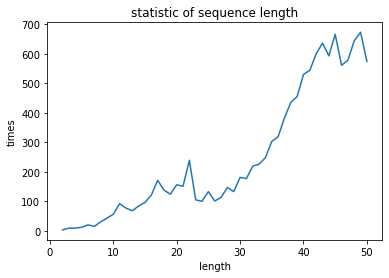

In [5]:
y_len, x_len = [], []
for k,v in sorted([(k,v) for k,v in len_seq.items()], key=lambda x: x[0]):
    y_len.append(v)
    x_len.append(k)
plot_coh(y_len, x_len, 'times', 'length', 'statistic of sequence length')

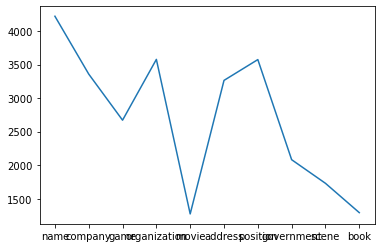

In [6]:
plot_coh([v for k,v in ct_label.items()], [k for k,v in ct_label.items()])

In [7]:
label_uniq = []
for k, _ in ct_label.items():
    k = k.upper()
    label_uniq.extend([f'{prefix}-{k}' for prefix in ['B', 'I', 'E']])
label_uniq.extend(['O', 'B-POS', 'E-POS'])
label_uniq

['B-NAME',
 'I-NAME',
 'E-NAME',
 'B-COMPANY',
 'I-COMPANY',
 'E-COMPANY',
 'B-GAME',
 'I-GAME',
 'E-GAME',
 'B-ORGANIZATION',
 'I-ORGANIZATION',
 'E-ORGANIZATION',
 'B-MOVIE',
 'I-MOVIE',
 'E-MOVIE',
 'B-ADDRESS',
 'I-ADDRESS',
 'E-ADDRESS',
 'B-POSITION',
 'I-POSITION',
 'E-POSITION',
 'B-GOVERNMENT',
 'I-GOVERNMENT',
 'E-GOVERNMENT',
 'B-SCENE',
 'I-SCENE',
 'E-SCENE',
 'B-BOOK',
 'I-BOOK',
 'E-BOOK',
 'O',
 'B-POS',
 'E-POS']

In [8]:
# 处理 label
def handle_labels(labels):
    """
    处理 lables, 方便后续使用。

    处理结果：每行返回一个 dict, key 为 label name, value 当前 label 的 idx 范围，[(start, end)].

    Args:
        labels ([dict]): 数据 label
    Return:
        res(list(dict)): [{label: [(start, end)]}], 不包含 end.
    """
    res = []
    for label_line in labels:
        cur = {}
        for name_label, detail_label in label_line.items():
            scopes_cur_label = []
            for _, scopes in detail_label.items():
                scopes_cur_label.extend([(s[0], s[1] + 1) for s in scopes])
            cur[name_label] = scopes_cur_label
        res.append(cur)
    return res

In [9]:
labels[0], handle_labels(labels[:1])

({'name': {'叶老桂': [[9, 11]]}, 'company': {'浙商银行': [[0, 3]]}},
 [{'name': [(9, 12)], 'company': [(0, 4)]}])

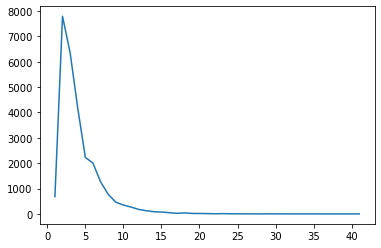

In [10]:
# 统计 label tokenize 后的长度

ctr = collections.Counter()
for label in labels:
    for _, label_detail in label.items():
        for content, scopes in label_detail.items():
            ctr.update([len(tokenizer.tokenize(content))] * len(scopes))

cts_label, len_label = [], []
for  length, times in sorted([(k,v) for k,v in ctr.items()], key=lambda x: x[0]):
    cts_label.append(times)
    len_label.append(length)

plot_coh(cts_label, len_label)

In [11]:
tokenize_chinese(tokenizer, '微软分为1234f2从VS的', True)

(['微', '软', '分', '为', '1234', '##f', '##2', '从', 'vs', '的'],
 <my_py_toolkit.ml.data.text_preprocess.IdxTransfer at 0x2c086bbac40>)

In [12]:
# 处理 token, labels, 返回每个 token 的 label。

def check_token_label(label_ori, idx_transfer):
    """
    检查 token 的 label 是否正确。（主要看 tokenize 后label 与 toekn 是否一一对应， tokenize 有 token 可能包含多个字符。）

    1、根据 label 的起始位置找到 token 的起始位置
    2、根据找到的 token 起始位置找到对应的 label 起始位置 label_token
    3、比较 label 与 token label 是否一致。

    Args:
        label_ori (list(int)): label 在原始文本中标注的 idx 范围（start, end）, 不包含 end.
        idx_transfer:
        # new2ori_idx (list((start, end))): token 与原文本的对应关系, 不包含 end.
        # ori2new_idx (list(int)): 原文本与 token 的对应关系。
    """
    start, end = label_ori
    start_token, end_token =idx_transfer.to_new(start), idx_transfer.to_new(end)
    if start == idx_transfer.to_ori(start_token) and end == idx_transfer.to_ori(end_token):
        return True
    else:
        return False
    
def generate_label(name_label, nums_label, split=False):
    """
    生成 label.

    Args:
        name_label (str): 标签名。
        nums_label (int): 标签个数。
        split (bool, optional): 是否拆分标签. Defaults to False. 若为 true, 根据标签个数加上前缀 'B-'(前)、'I-'(中)、'E-'(后)
    """
    assert nums_label > 0
    
    name_label = name_label.upper()
    if not split:
        return [name_label] * nums_label
    else:
        label_gene = []
        for i in range(nums_label):
            if i==0:
                label_gene.append("B-" + name_label)
            elif i > 0 and i < nums_label - 1:
                label_gene.append("I-" + name_label)
            else:
                label_gene.append("E-" + name_label)
        return label_gene

def conv_new_idx(ori2new_idx, ori_idx):
    """
    将原始 idx 转换为新的 token idx.

    Args:
        ori2new_idx (list(int)): 原始 idx 与 token idx 的映射关系。
        ori_idx (int): 原始 idx。
    """
    if len(ori2new_idx) - 1 > ori_idx:
        return ori2new_idx[ori_idx]
    else:
        return ori2new_idx[ori_idx - 1] + 1

def conv2tok_lab_pair(source, labels, tokenizer, split_label=False):
    """
    将数据转换为 (token, label) 对。

    Args:
        source (list(str)): 原文本
        labels (list(dict{label: [(start, end)]})): 原数据 label。scope 包含 end。
        tokenizer (Tokenizer): 对文本进行 tokenize 操作的类。
        split_label(bool): 是否拆分 label, 如: name 拆为: B-NAME, I-NAME, E-NAME.
    
    Return:
        (list((tokens, label))): 返回 source 中每个 txt 的 token 与 label 对。
    """
    pairs = []
    for txt, label_detail in zip(source, labels):
        tokens, idx_tranfer = tokenize_chinese(tokenizer, txt, True)
        labels_tokens = ["O"] * len(tokens)
        is_valid = True
        for name_label, scopes in label_detail.items():
            if not all([check_token_label(s, idx_tranfer) for s in scopes]):
                is_valid = False
                break
            for start, end in scopes:
                start_token, end_token = idx_tranfer.to_new(start), idx_tranfer.to_new(end)
                labels_tokens[start_token:end_token] = generate_label(name_label, end_token - start_token, split_label)
        if not is_valid:
            print(f"Label error: ==================\ntxt: {txt}, label：{label_detail}")
        else:
            pairs.append((tokens, labels_tokens))
    return pairs
                
        
    

In [13]:
pairs = conv2tok_lab_pair(sources, handle_labels(labels), tokenizer, split_token)
pairs[:3]

Label error: ==================
txt: Moon星际2无力GSLA级预选落败, label：{'game': [(4, 7)], 'organization': [(9, 12)], 'name': [(0, 4)]}
Label error: ==================
txt: StarCraft2Forum在倒计时的上方有一行字：“它将来临……”, label：{'game': [(0, 10)]}
Label error: ==================
txt: 朴茨茅斯队vsac米兰队两队在欧洲三大杯历史上没有交锋战绩。, label：{'organization': [(0, 5), (7, 12)]}
Label error: ==================
txt: 最后一种模式和War3DotA中的死亡模式类似，当你的英雄死亡，, label：{'game': [(7, 11), (11, 15)]}
Label error: ==================
txt: CPL2011中国区第三阶段线上选拔赛WAR3项目终于决出晋级复赛的名单。人族天王, label：{'game': [(19, 23)], 'organization': [(0, 4)]}
Label error: ==================
txt: 布鲁日vs圣埃蒂安、nec奈梅亨vs热刺、朴茨茅斯vsac米兰。, label：{'organization': [(0, 3), (5, 9), (10, 16), (18, 20), (21, 25), (27, 31)]}
Label error: ==================
txt: 之前是魔兽3solo现在各类游戏都发展起来了所以我觉得只要是wcg正式的项目, label：{'game': [(3, 6)], 'organization': [(30, 33)]}
Label error: ==================
txt: 14.朴茨茅斯vsac米兰, label：{'organization': [(3, 7), (9, 13)]}
Label error: ==================
txt: 都灵vsac米兰推

[(['浙',
   '商',
   '银',
   '行',
   '企',
   '业',
   '信',
   '贷',
   '部',
   '叶',
   '老',
   '桂',
   '博',
   '士',
   '则',
   '从',
   '另',
   '一',
   '个',
   '角',
   '度',
   '对',
   '五',
   '道',
   '门',
   '槛',
   '进',
   '行',
   '了',
   '解',
   '读',
   '。',
   '叶',
   '老',
   '桂',
   '认',
   '为',
   '，',
   '对',
   '目',
   '前',
   '国',
   '内',
   '商',
   '业',
   '银',
   '行',
   '而',
   '言',
   '，'],
  ['B-COMPANY',
   'I-COMPANY',
   'I-COMPANY',
   'E-COMPANY',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B-NAME',
   'I-NAME',
   'E-NAME',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['生',
   '生',
   '不',
   '息',
   'cs',
   '##ol',
   '生',
   '化',
   '狂',
   '潮',
   '让',
   '你',
   '填',
   '弹',
   '狂',
   '扫'],
  ['O',
   'O',
 

In [14]:
# 尽你的一切可能来离开这片区域吧。经验有时候会骗自己，而dota中眼睛永远不会。, label：{'game': [(27, 30)]}
txt = '朴茨茅斯队vsac米兰队两队在欧洲三大杯历史上没有交锋战绩。'
label = {'address': [(28, 30)], 'movie': [(4, 10), (12, 26), (33, 37)]}
tokens, idx_transfer = tokenize_chinese(tokenizer, txt, True)
print(idx_transfer.ori2new_idx), print(idx_transfer.new2ori_idx)

[0, 1, 2, 3, 4, 5, 5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30)]


(None, None)

In [15]:
# 检查不对的数据
def check_label(txt, label):
    tokens, idx_transfer = tokenize_chinese(tokenizer, txt, True)
    for name_label, scopes in label.items():
        for start, end in scopes:
            print(f"{start}, {end}; {check_token_label((start, end), idx_transfer)}")
            s_t = idx_transfer.to_new(start)
            e_t = idx_transfer.to_new(end)
            s_to = idx_transfer.to_ori(s_t)
            e_to = idx_transfer.to_ori(e_t)
            print(f"txx: {txt[start:end]}, tokens: {tokens[s_t:e_t]}, token to txt: {txt[s_to:e_to]}")


In [16]:
check_label(txt, label)

28, 30; True
txx: 绩。, tokens: ['绩', '。'], token to txt: 绩。
4, 10; True
txx: 队vsac米, tokens: ['队', 'vsa', '##c', '米'], token to txt: 队vsac米
12, 26; True
txx: 两队在欧洲三大杯历史上没有交, tokens: ['两', '队', '在', '欧', '洲', '三', '大', '杯', '历', '史', '上', '没', '有', '交'], token to txt: 两队在欧洲三大杯历史上没有交
33, 37; False
txx: , tokens: [], token to txt: 


In [24]:

# 
def convert_features(pairs, max_len, tags_mapping, tokenizer):
    """
    转换为模型输入。

    Args:
        pairs (list(tuple)): [description]
        max_len (int): [description]
        tags_mapping (dict): [description]
        tokenizer (Tokenizer): [description]

    Returns:
        tuple: inputs_idx, labels_idx, segments, mask
    """
    inputs_idx = []
    segments = []
    labels_idx = []
    mask = []
    
    for tokens, labels in pairs:
        tokens = ['[CLS]'] + tokens[:max_len - 2] + ['[SEP]']
        labels = ['[CLS]'] + labels[:max_len - 2] + ['[SEP]']
        segment = [0] * max_len
        cur_mask = [1] * len(tokens)
        
        tokens +=  ['[PAD]'] * (max_len - len(tokens))
        labels +=  ['O'] * (max_len - len(labels))
        cur_mask += [0] * (max_len - len(cur_mask))
        
        inputs_idx.append(tokenizer.convert_tokens_to_ids(tokens))
        segments.append(segment)
        labels_idx.append([tags_mapping[label] for label in labels])
        mask.append(cur_mask)
    
    return inputs_idx, labels_idx, segments, mask
        
        

In [25]:
inputs_idx, labels_idx, segments, mask = convert_features(pairs, max_len, tags_mapping, tokenizer)
inputs_idx[:2]

[[101,
  3851,
  1555,
  7213,
  6121,
  821,
  689,
  928,
  6587,
  6956,
  1383,
  5439,
  3424,
  1300,
  1894,
  1156,
  794,
  1369,
  671,
  702,
  6235,
  2428,
  2190,
  758,
  6887,
  7305,
  3546,
  6822,
  6121,
  749,
  6237,
  6438,
  511,
  1383,
  5439,
  3424,
  6371,
  711,
  8024,
  2190,
  4680,
  1184,
  1744,
  1079,
  1555,
  689,
  7213,
  6121,
  5445,
  6241,
  8024,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [28]:
torch.tensor(inputs_idx[:2], dtype=torch.long)

tensor([[ 101, 3851, 1555,  ...,    0,    0,    0],
        [ 101, 4495, 4495,  ...,    0,    0,    0]])

In [4]:
from my_py_toolkit.file.file_toolkit import writejson, readjson
from torch.utils.data import DataLoader, IterableDataset
import random

In [40]:
class FileDataset(IterableDataset):
    def __init__(self, paths, shuffle=False):
        super().__init__()
        self.paths = paths
        self.shuffle = shuffle
        self.size = 0
        for p in self.paths:
            self.size += len(readjson(p)[0])
        
    
    def __iter__(self):
        for p in self.paths:
            datas = readjson(p)
            idx = list(range(len(datas[0])))
            if self.shuffle:
                random.shuffle(idx)
            for i in idx:
                yield [item[i] for item in datas]

    def __len__(self):
        return self.size
    




In [38]:
a = [list(range(100)), list(range(100, 200)), ['啊'] * 1000]
writejson(a, './test.json')
a = [list(range(200,300)), list(range(300, 400)), ['哈'] * 1000]
writejson(a, './test1.json')

In [43]:
dataset = FileDataset(['./test.json', './test1.json'], shuffle=True)
dl = DataLoader(dataset, 1)

In [44]:
len(dl)

200

In [36]:
for v in dl:
    print(v)

[tensor([35, 45]), tensor([135, 145]), ('啊', '啊')]
[tensor([64, 41]), tensor([164, 141]), ('啊', '啊')]
[tensor([57, 36]), tensor([157, 136]), ('啊', '啊')]
[tensor([20, 40]), tensor([120, 140]), ('啊', '啊')]
[tensor([13,  2]), tensor([113, 102]), ('啊', '啊')]
[tensor([79, 12]), tensor([179, 112]), ('啊', '啊')]
[tensor([42, 95]), tensor([142, 195]), ('啊', '啊')]
[tensor([55, 83]), tensor([155, 183]), ('啊', '啊')]
[tensor([33, 97]), tensor([133, 197]), ('啊', '啊')]
[tensor([69, 94]), tensor([169, 194]), ('啊', '啊')]
[tensor([19,  6]), tensor([119, 106]), ('啊', '啊')]
[tensor([26, 14]), tensor([126, 114]), ('啊', '啊')]
[tensor([49, 96]), tensor([149, 196]), ('啊', '啊')]
[tensor([ 0, 84]), tensor([100, 184]), ('啊', '啊')]
[tensor([63, 67]), tensor([163, 167]), ('啊', '啊')]
[tensor([81, 51]), tensor([181, 151]), ('啊', '啊')]
[tensor([65,  1]), tensor([165, 101]), ('啊', '啊')]
[tensor([54, 52]), tensor([154, 152]), ('啊', '啊')]
[tensor([37, 76]), tensor([137, 176]), ('啊', '啊')]
[tensor([22, 11]), tensor([122,